# Self-Driving Car Engineer Nanodegree


## Project: **Finding Driving Lane Lines on the Road** 
***

As humans, we are naturally able to identify the driving lanes on a road. This is necessary for the vehicles we drive remain within their lane. Naturally, thi is a very important aspect of driving as it minimizes the chances of collisions with other cars.  

This is one of the first things we would expect an autonomous vehicle to perform. Unlike humanity however, computers do not naturally see and when we do empower them with cameras, they do not understand what they see. To detect driving lanes, we can use some well known computer vision techniques. Below, we describe these techniques and show how they can be applied (using Python and OpenCV) to detect driving lanes.  

---

### Import packages

We'll start by importing some useful packages. 

In [1]:
# standard packages
import numpy as np
import math
import os

# image processing packages
import matplotlib.image as mpimg
import cv2

# visualization packages
import matplotlib.pyplot as plt

The following command ensures that any plots are rendered within the notebook.  

In [2]:
# show plots inline
%matplotlib inline

### General Approach 

There are a number of ways to detect driving lanes from images and the following is one such (relatively simple) approach: 

1. Convert original image to HSL
2. Isolate yellow and white areas to reduce noise
3. Combine isolated HSL with original image
4. Convert to grayscale to reduce noise
5. Apply Gaussian Blur to smoothen edge
6. Apply Canny Edge Detection to detect edges
7. Mask to show only features in our region Of interest
8. Apply Hough Transformation to find lanes
9. Separate left and right lanes
10. Find lines of best fit for both left and right lanes
11. Overlay lines over original image

We'll start by developing a pipeline on a series of individual images. Later we show how this can easily be extended to videos (which are really just a series of images). We will use the following sample images of 960 x 540 pixels for developing and testing our pipelines.  

In [67]:
test_img_dir = "test_images/"

original_image_names = os.listdir(test_img_dir)

original_image_names = list(map(lambda name: test_img_dir + name, 
                                original_image_names))

print(original_image_names)

['test_images/solidYellowLeft.jpg', 'test_images/solidYellowCurve.jpg', 'test_images/solidYellowCurve2.jpg', 'test_images/solidWhiteCurve.jpg', 'test_images/solidWhiteRight.jpg', 'test_images/whiteCarLaneSwitch.jpg']


In [101]:
def show_image_list(img_list, 
                    cols=2, 
                    fig_size=(10, 10),
                    img_labels=original_image_names, 
                    cmap=None):
    
    """
    Show a list of images
    """
    
    img_count = len(img_list)
    
    rows = np.ceil(img_count / cols)
    
    plt.figure(figsize=fig_size)
        
    for i in range(0, img_count):
        
        img_name = img_labels[i]
        
        plt.subplot(rows, cols, i+1)
        
        img = img_list[i]
                
        # no ticks on axes
        plt.xticks([])
        plt.yticks([])
        
        # plot title
        plt.title(img_name[len(test_img_dir):])    
        
        # show plot 
        plt.imshow(img, cmap=cmap)

    plt.tight_layout()
    plt.show()

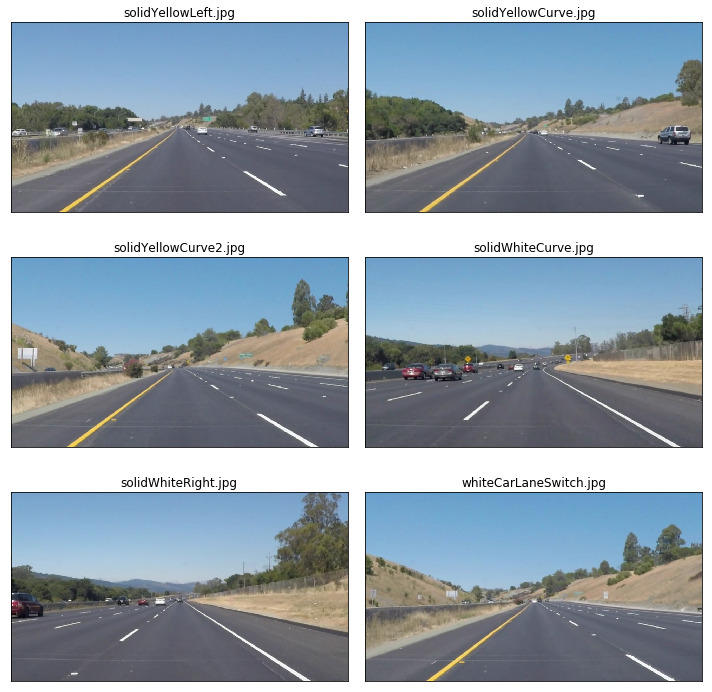

In [102]:
original_images = list(map(lambda img: mpimg.imread(img), 
                           original_image_names))

show_image_list(img_list = original_images)

There are few immediately obvious challenges we need to be mindful of while building a generalized pipeline for deteting lanes in these images:  

1. While the lane lines are generally coloured white, they can also be yellow. 
2. While most of these images depict only light traffic, some of them have other cars in them and what's worse is that some cars are colored white! 
3. All of these images depict fairly straight patches of road. It is obviously possible for roads and therefore our lane lines to be curved.   

### Step 1: Convert image to HSL

There are a number of color models, below is a brief introduction to two of the most popular models in use today.   

#### RGB 

The most commonly used model is the RGB model which defines a color space in terms of three components:

- Red, which ranges from 0-255
- Green, which ranges from 0-255
- Blue, which ranges from 0-255

The RGB color model is additive i.e. Red, Green and Blue values are combined to reproduce other colors. 

<figure>
 <img src="supporting_images/rgb.png"/>
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> RGB color model </p> 

#### HSL 

The HSL color space stands for:

- Hue : the color type (such as red, blue, or yellow). Ranges from 0 to 360° in most applications (each value corresponds to one color : 0 is red, 45 is a shade of orange and 55 is a shade of yellow).
- Saturation : variation of the color depending on the lightness. Ranges from 0 to 100% (from the center of the black&white axis).
- Lightness (also Luminance or Luminosity or Intensity). Ranges from 0 to 100% (from black to white).

<figure>
 <img src="supporting_images/hsl.png"/>
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> HSL color moderl </p> 


There are other color models out there too including HSB, CMYK, and YUV. Like most images however, all of our images are in RBG format. So why are we talking about other color models? We suspect that it might be easier to isolate driving lanes in other color spaces than RGB. So let's have a look at our test images in HSL.    

In [103]:
def hsl(img):
    """
    convert image to hsl
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

In [ ]:
hsl_images = list(map(lambda img: hsl(img), 
                      original_images))

RGB color model


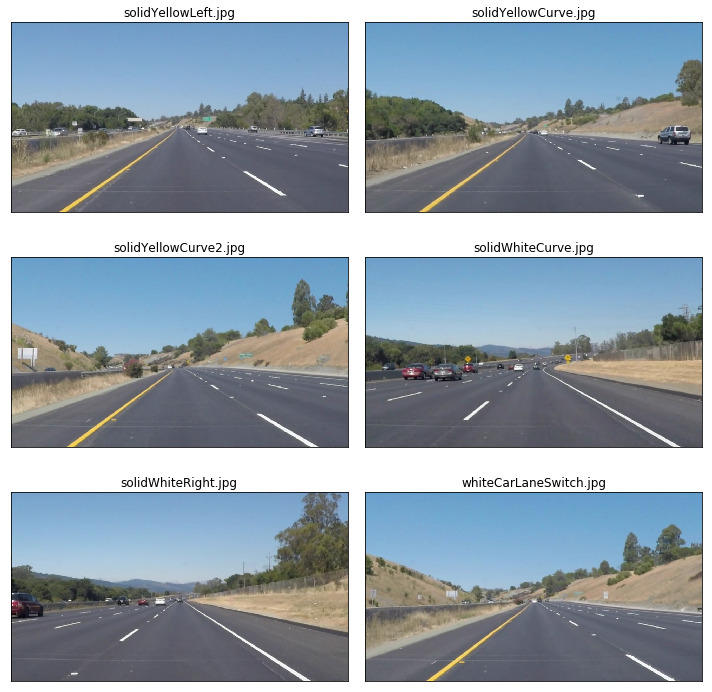

HSL color model


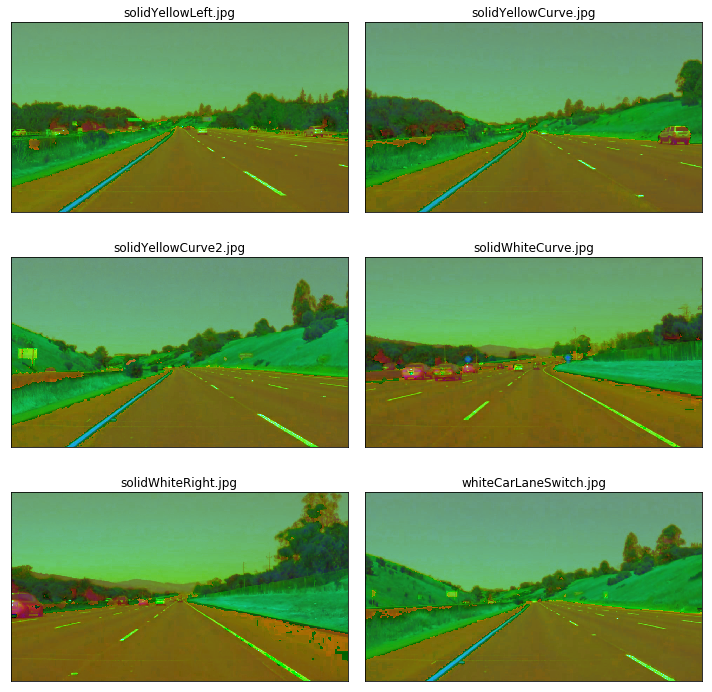

In [104]:
print('RGB color model')
show_image_list(img_list = original_images)
print('HSL color model')
show_image_list(img_list = hsl_images)

Looking at the above, we can see that HSL shows better contrast between the lane lines and the road when compared to RGB.  

### Step 2: Isolate yellow and white areas


In [105]:
def isolate_yellow_hsl(img):
    """
    
    """
    # Lower value equivalent pure HSL is (30, 45, 15)
    low_threshold = np.array([15, 38, 115], dtype=np.uint8)
    # Higher value equivalent pure HSL is (75, 100, 80)
    high_threshold = np.array([35, 204, 255], dtype=np.uint8)  
    
    masked_img = cv2.inRange(img, low_threshold, high_threshold)
    
    return masked_img
                            
def isolate_white_hsl(img):
    """
    
    """
    # Lower value equivalent pure HSL is (30, 45, 15)
    low_threshold = np.array([0, 200, 0], dtype=np.uint8)
    # Higher value equivalent pure HSL is (360, 100, 100)
    high_threshold = np.array([180, 255, 255], dtype=np.uint8)  
    
    masked_img = cv2.inRange(img, low_threshold, high_threshold)
    
    return masked_img

In [106]:
hsl_yellow_images = list(map(lambda img: isolate_yellow_hsl(img), 
                             hsl_images))

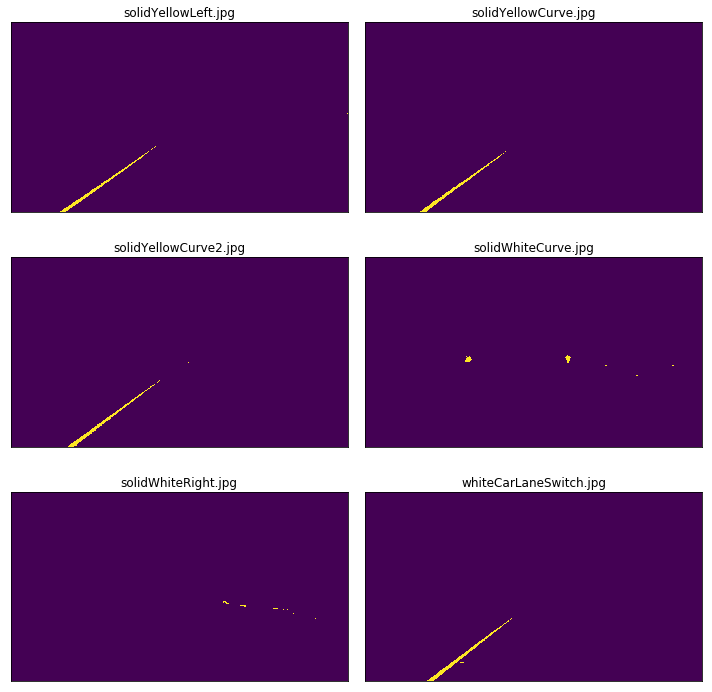

In [107]:
show_image_list(img_list = hsl_yellow_images)

Now let's do the same for the white components of our images. 

In [108]:
hsl_white_images = list(map(lambda img: isolate_white_hsl(img), 
                            hsl_images))

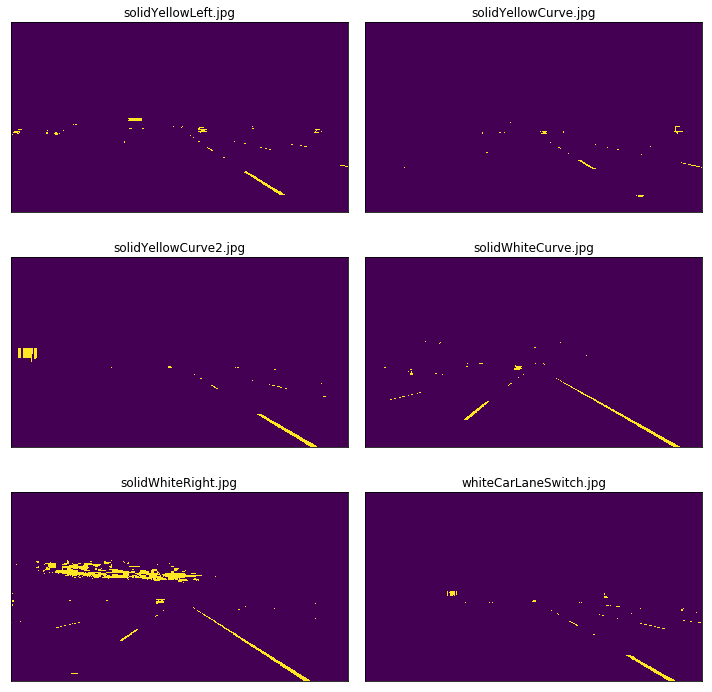

In [109]:
show_image_list(img_list = hsl_white_images)

We can observe how the yellow and the white of the lanes are very well isolated. Let's now combine those two masks using an OR operation and then combine with the original image using an AND operation to only retain the intersecting elements.

In [110]:
def combine_hsl_isolated_with_original(img, hsl_yellow, hsl_white):
    hsl_mask = cv2.bitwise_or(hsl_yellow, hsl_white)
    return cv2.bitwise_and(img, img, mask=hsl_mask)

def filter_img_hsl(img):
    hsl_img = hsl(img)
    hsl_yellow = isolate_yellow_hsl(hsl_img)
    hsl_white = isolate_white_hsl(hsl_img)
    return combine_hsl_isolated_with_original(img, hsl_yellow, hsl_white)

In [111]:
combined_hsl_images = list(map(lambda img: filter_img_hsl(img), 
                               original_images))

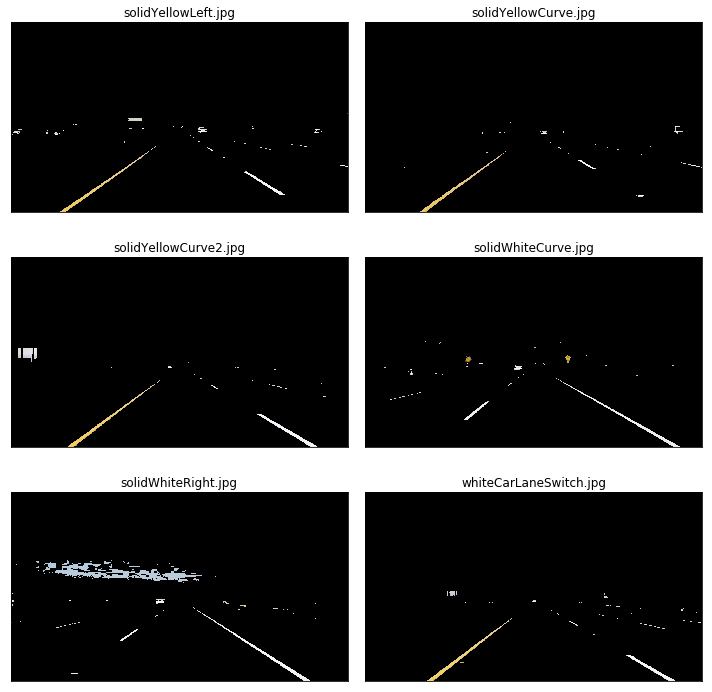

In [112]:
show_image_list(img_list = combined_hsl_images)

This is looking pretty good. We can clearly see yellow and white elements in our images. 

### Step 4: Convert to grayscale 

Our conversion from RGB to has helped in reduce the amount of noise in our image. We can go one step further by converting the HSL image to grayscale. We're interested in detecting white or yellow lines on images and given that roads are generally black, anything much brighter on the road will come out with an even higher contrast on a grayscale image.  

In [113]:
def grayscale(img):
    """
    Applies Grayscale transform
    To see the returned image as grayscale you should call plt.imshow(gray, cmap='gray')
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [114]:
grayscale_images = list(map(lambda img: grayscale(img), 
                            combined_hsl_images))

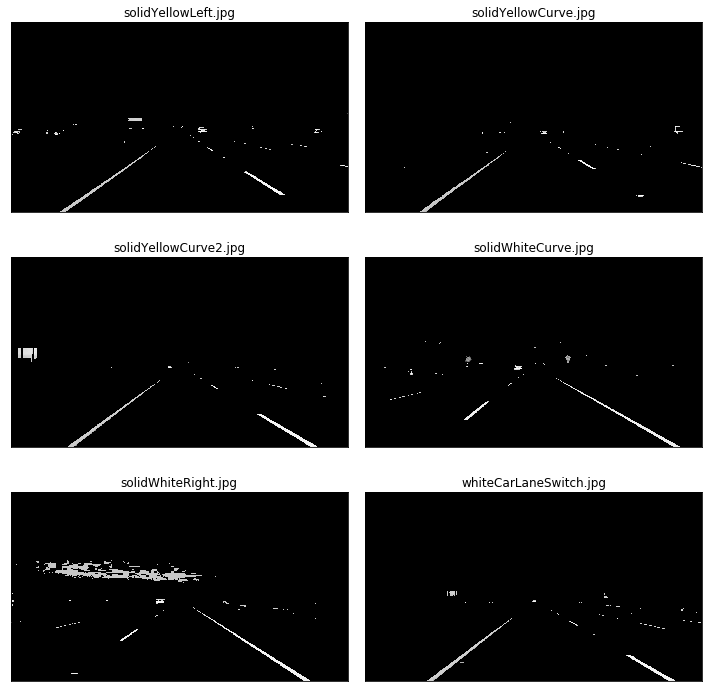

In [115]:
show_image_list(img_list = grayscale_images, cmap='gray')

Some description. 

### Step 5: Apply Gaussian Blur

To smoothen edges. 

In [118]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [119]:
blur_images = list(map(lambda img: gaussian_blur(img, kernel_size=5), 
                            grayscale_images))

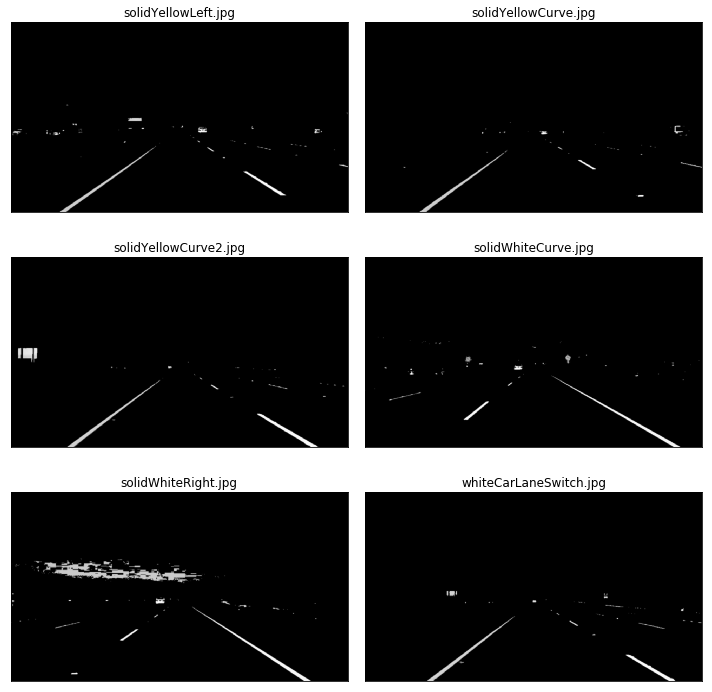

In [121]:
show_image_list(img_list = blur_images, cmap='gray')

### Step 6 Detect edges 

Using canny edge detection algorithm. 

In [122]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

In [123]:
edge_images = list(map(lambda img: canny(img=img, 
                                         low_threshold=50, 
                                         high_threshold=150), 
                       blur_images))

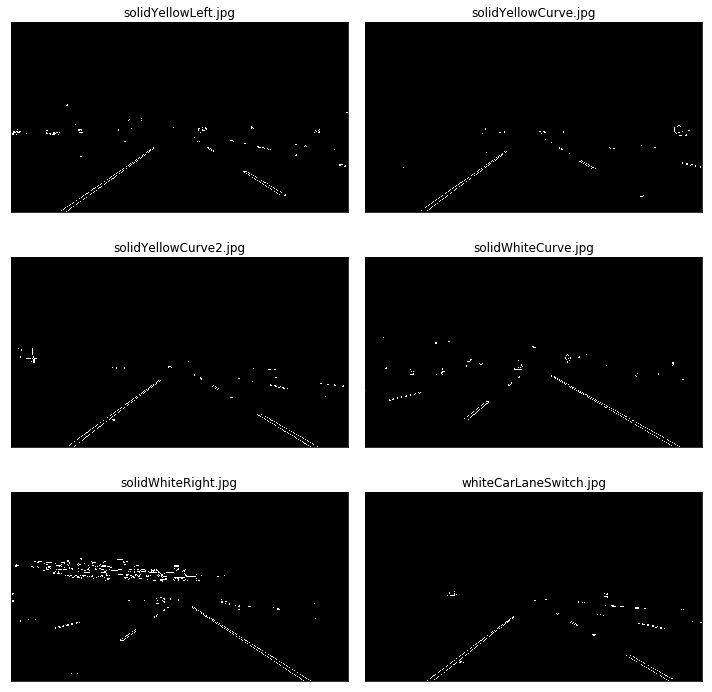

In [125]:
show_image_list(img_list = edge_images, cmap='gray')

### Step 7: Isolate region of interest 

Reduce noise even further. 

In [132]:
def vertices(img):

    imshape = img.shape
    
    # Define a quadrilateral
    vert = np.array([[(0, imshape[0]),
                      (450, 320), 
                      (490, 320), 
                      (imshape[1], imshape[0])]], 
                    dtype=np.int32)
    return vert

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [135]:
masked_images = list(map(lambda img: region_of_interest(img=img, 
                                                        vertices=vertices(img)), 
                         edge_images))

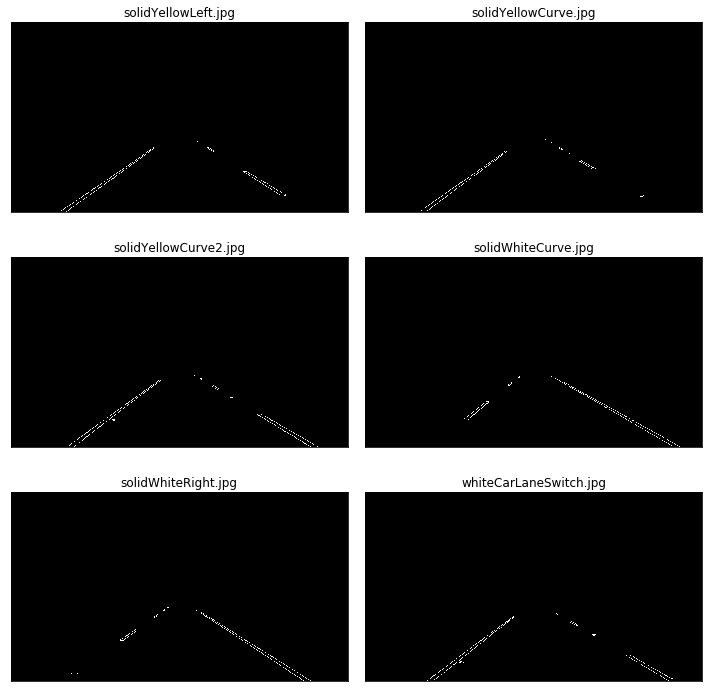

In [137]:
show_image_list(img_list = masked_images, cmap='gray')

### Step 8: Apply Hough Transformation

In [139]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    Extrapolate detected line segments    
    """ 
        
    x=[]
    y=[]
    slope=[]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            x.append(x1)
            x.append(x2)
            
            y.append(y1)
            y.append(y2)
            
            slope.append((y2-y1)/(x2-x1))
            slope.append((y2-y1)/(x2-x1))
            
    x_array = np.array(x)
    y_array = np.array(y)
    slope_array = np.array(slope)
    
    # seperate into left and right lines using mid_point
    
    mid_point = np.int(img.shape[1]/2)
    
    left_x_index = np.where(x_array<mid_point)
    right_x_index = np.where(x_array>mid_point)
    
    left_x = x_array[left_x_index]
    left_y = y_array[left_x_index]
    
    right_x = x_array[right_x_index]
    right_y = y_array[right_x_index]
    
    # seperate into left and right lines using slope
    
    #left_x_index = np.where((slope_array>0.3) & (slope_array<math.inf))
    #right_x_index = np.where((slope_array<-0.3) & (slope_array>-math.inf))

    #left_x = x_array[left_x_index]
    #left_y = y_array[left_x_index]
    
    #right_x = x_array[right_x_index]
    #right_y = y_array[right_x_index]

    # calculate line-of-best-fit for left and right seperately
    
    line_y_limit = np.int(img.shape[0]*(6/10))
    
    left_m, left_b = np.polyfit(x=left_x, y=left_y, deg=1)
    right_m, right_b = np.polyfit(x=right_x, y=right_y, deg=1)

    left_y1 = line_y_limit
    left_x1 = np.int((left_y1-left_b)/left_m)
    
    left_y2 = img.shape[0]
    left_x2 = np.int((left_y2-left_b)/left_m)
    
    right_y1 = line_y_limit
    right_x1 = np.int((right_y1-right_b)/right_m)
    
    right_y2 = img.shape[0]
    right_x2 = np.int((right_y2-right_b)/right_m)
    
    # add lines to image
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)
    cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


/home/fqaiser94/.local/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in int_scalars
/home/fqaiser94/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in int_scalars


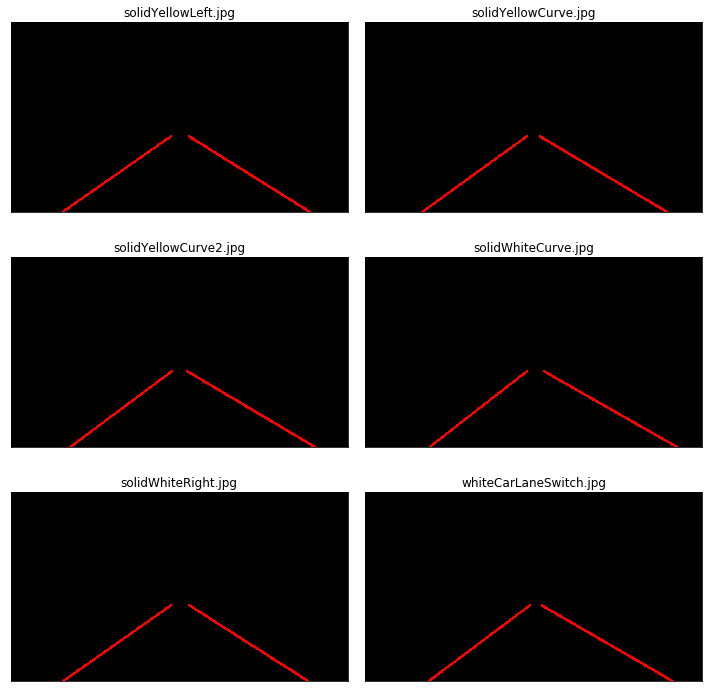

In [140]:
# Define the Hough transformation parameters
# distance resolution in pixels of the Hough grid
rho = 1 

# angular resolution in radians of the Hough grid
theta = np.pi/180 

# minimum number of votes (intersections in Hough grid cell)
threshold = 1     

#minimum number of pixels making up a line
min_line_length = 1

# maximum gap in pixels between connectable line segments
max_line_gap = 1 

hough_line_images = list(map(lambda img: hough_lines(img=img, 
                                                     rho=rho,
                                                     theta=theta,
                                                     threshold=threshold,
                                                     max_line_gap=max_line_gap, 
                                                     min_line_len=min_line_length), 
                       masked_images))

show_image_list(img_list = hough_line_images)

#### Overlay lines and image

In [141]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

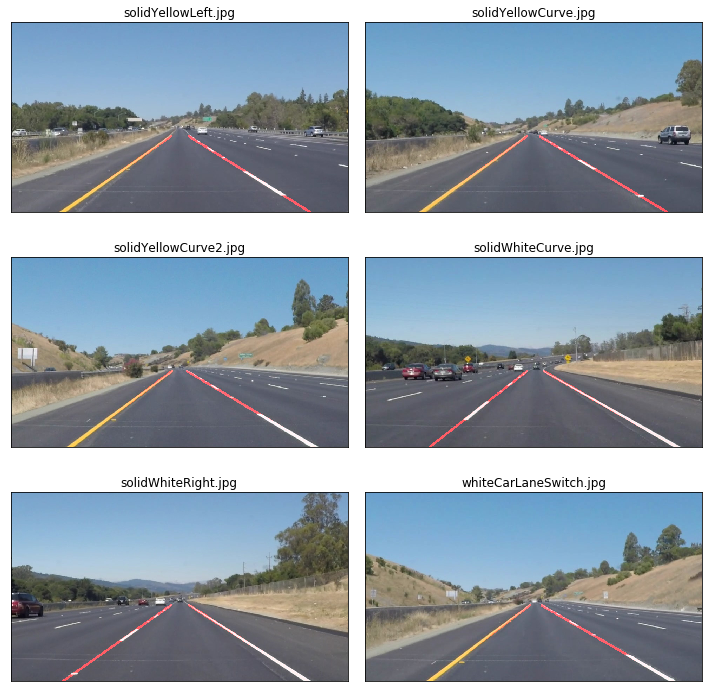

In [144]:
overlay_images = list(map(lambda img, og_img: weighted_img(img=img,
                                                   initial_img=og_img, 
                                                   α=1, 
                                                   β=0.8, 
                                                   λ=0), 
                       hough_line_images, original_images))

show_image_list(img_list = overlay_images)

#### Bring it all together

Now let's combine all of the above functions into one with our best parameters.  

In [147]:
def process_image(image, show_plots=False):
    """
    One function to rule them all
    """
    if show_plots==True:
        plt.imshow(image)
        plt.show()
    
    # convert image to hsl
    image_hsl = filter_img_hsl(image)
    
    if show_plots==True:
        plt.imshow(image_hsl)
        plt.show()
    
    # convert image to gray scale
    image_gray = grayscale(image_hsl)
    
    if show_plots==True:
        plt.imshow(image_gray, cmap='gray')
        plt.show()

    # Define a kernel size and apply Gaussian smoothing
    blur_gray = gaussian_blur(img=image_gray, 
                              kernel_size=5)
    
    if show_plots==True:
        plt.imshow(blur_gray, cmap='gray')
        plt.show()

    # apply canny edge detection
    edges = canny(img=blur_gray, 
                  low_threshold=50, 
                  high_threshold=150)
    
    if show_plots==True:
        plt.imshow(edges, cmap='gray')
        plt.show()

    # isolate region of interest
    imshape = image.shape

    vert = np.array([[(0,imshape[0]),
                      (450, 320), 
                      (490, 320), 
                      (imshape[1],imshape[0])]], 
                    dtype=np.int32)

    masked = region_of_interest(img=edges, vertices=vert)
    
    if show_plots==True:
        plt.imshow(masked, cmap='gray')
        plt.show()

    # Define the Hough transformation parameters
    # distance resolution in pixels of the Hough grid
    rho = 1 

    # angular resolution in radians of the Hough grid
    theta = np.pi/180 

    # minimum number of votes (intersections in Hough grid cell)
    threshold = 1     

    #minimum number of pixels making up a line
    min_line_length = 1

    # maximum gap in pixels between connectable line segments
    max_line_gap = 1 

    # creating a blank to draw lines on
    #line_image = np.copy(image)*0 

    color_edges = hough_lines(img=masked, 
                              rho=rho,
                              theta=theta,
                              threshold=threshold,
                              max_line_gap=max_line_gap, 
                              min_line_len=min_line_length
                             )
    if show_plots==True:
        plt.imshow(color_edges)
        plt.show()
    
    color_edges_overlaid = weighted_img(img=color_edges,
                                        initial_img=image, 
                                        α=1, 
                                        β=0.8, 
                                        λ=0)
    
    if show_plots==True:
        plt.imshow(color_edges_overlaid)
        plt.show()
    else: 
        #return np.concatenate((image_gray, masked), axis=1)
        #return np.hstack((image_gray, masked))
        return color_edges_overlaid

Lets test our function on all the images to see how well it worked.  

/home/fqaiser94/.local/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in int_scalars
/home/fqaiser94/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in int_scalars


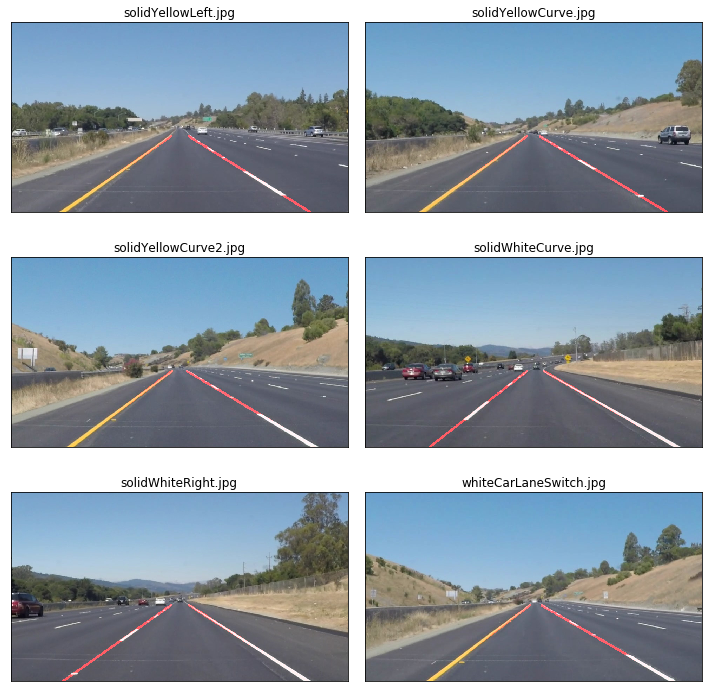

In [148]:
all_test_images = list(map(lambda img: process_image(img, show_plots=False), 
                           original_images))

show_image_list(img_list=all_test_images)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [149]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [150]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:03<00:00, 66.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.51 s, sys: 224 ms, total: 2.73 s
Wall time: 3.74 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [151]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [152]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:11<00:00, 59.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 7.94 s, sys: 604 ms, total: 8.54 s
Wall time: 12 s


In [153]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [154]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:08<00:00, 30.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 5.17 s, sys: 324 ms, total: 5.49 s
Wall time: 9.05 s


In [155]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))